# Machine Learning - Main File

**By Jakke Neiro & Andrei Roibu** 

## 1. Importing All Required Dependencies

This script imports all the required dependencies for running the different functions and the codes. Also, by using the _run_ command, the various notebooks are imprted into the main notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp

import glob, os

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, roc_auc_score, confusion_matrix, classification_report, log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn import svm, datasets, tree
from sklearn.ensemble import RandomForestClassifier


from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler


In [2]:
os.chdir("./data")

## 2. Data Pre-Processing

This section imports all the required datasets as pandas dataframes, concatenates them, after which it pre-processes them by eliminating all non-numerical data and columns which contain the same data-values. This script also creates the input dataset and the labeled output dataset.

In [3]:
def data_preprocessing():
    
    '''
    This reads all the input datasets, pre-processes them and then generates the input dataset and the labelled dataset.
    
    Args:
        None
        
    Returns:
        X (ndarray): A 2D array containing the input processed data
        y (ndarray): A 1D array containing a list of labels, with 1 corresponding to "active" and 0 corresponding to "dummy"
        
    '''
    
    df_list = []
    y = np.array([])
    for file in glob.glob("egfr*.csv"):
        df = pd.read_csv(file, header = 0)

        cols = df.shape[0]
        if "actives" in file:
            y_df = np.ones((cols))
        else:
            y_df = np.zeros((cols))
        y = np.concatenate((y,y_df), axis=0)

        df_list.append(df)

    global_df = pd.concat(df_list, axis=0, ignore_index=True)
    global_df = global_df._get_numeric_data()
    global_df = global_df.loc[:, (global_df != global_df.iloc[0]).any()] 

    X_headers = list(global_df.columns.values)
    X = global_df.values
    
    return X,y

In [4]:
X,y = data_preprocessing()

In [5]:
def data_split(X,y):
    
    '''
    This function takes the original datasets and splits them into training and testing datasets.
    
    Args:
        X (ndarray): A 2D array containing the input processed data
        y (ndarray): A 1D array containing a list of labels, with 1 corresponding to "active" and 0 corresponding to "dummy"
        
    Returns:
        X_train (ndarray): 2D array of input dataset used for training
        X_test (ndarray): 2D array of input dataset used for testing
        y_train (ndarray): 1D array of train labels 
        y_test (ndarray): 1D array of test labels  
        
    '''

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = data_split(X,y)

## 3. Model Evaluation


This section produces the ROC plot, as well as several other performance metrics, including the classifier scores, the log-loss for each classifier, the confusion matrix and the classification report including the f1 score. The f1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

In [7]:
def ROC_plotting(title, y_test, y_score):
    
    '''
    This function generates the ROC plot for a given model.
    
    Args:
        title (string): String represending the name of the model.
        y_test (ndarray): 1D array of test dataset 
        y_score (ndarray): 1D array of model-predicted labels
        
    Returns:
        ROC Plot
        
    '''
    
    n_classes = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def model_evaluation(X_train, X_test, y_train, y_test, predicted_train, predicted_test, title="model"):
    
    '''
    This function prints the results of the different classifiers,a s well as several performance metrics
    
    Args:
        X_train (ndarray): 2D array of input dataset used for training
        X_test (ndarray): 2D array of input dataset used for testing
        y_train (ndarray): 1D array of train labels 
        y_test (ndarray): 1D array of test labels 
        title (string): the classifier name
        predicted_train (ndarray): 1D array of model-predicted labels for the train dataset 
        predicted_test (ndarray): 1D array of model-predicted labels for the test dataset
        
    Returns:
        ROC Plot
        
    '''
    
    print("For the ", title, " classifier:")
    print("Training set score: %f" % accuracy_score(y_train,predicted_train ))
    print("Training log-loss: %f" % log_loss(y_train, predicted_train))
    print("Training set confusion matrix:")
    print(confusion_matrix(y_train,predicted_train))
    print("Training set classification report:")
    print(classification_report(y_train,predicted_train))
    
    print("Test set score: %f" % accuracy_score(y_test, predicted_test))
    print("Test log-loss: %f" % log_loss(y_test, predicted_test))
    print("Test set confusion matrix:")
    print(confusion_matrix(y_test,predicted_test))
    print("Test set classification report:")
    print(classification_report(y_test,predicted_test))

    ROC_plotting("ROC for "+ title,y_test, predicted_test)

## 4. Logistic regression, linear and quadratic discriminant analysis

### 4.1. Logistic regression

Logistic regression (logit regression, log-liner classifier) is a generalized linear model used for classification that uses a log-linear link function to model the outcome of a binary reponse variable $\mathbf{y}$ using a single or multiple predictors $\mathbf{X}$. Mathematically, the logistic regression primarily computes the probability of the value of a response variable given a value of the predictor, and this probability is then used for predicting the most probable outcome. The logistic regression has several advantages: it is easy to implement, it is efficient to train and it does not require input features to be scaled. However, the logistic regression can only produce a non-linear decision boundary. Therefore, with a complex dataset as ours, we do not expect it to perform particularly well.

In [9]:
def LogReg(X_train, y_train, X_test):
    """Classification using logistic regression 

    Args:
        X_train: Predictor or feature values used for training
        y_train: Response values used for training
        X_test: Predictor or feature values used for predicting the response values using the classifier

    Returns:
        y_predicted: The predicted response values

    """
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Define and train the model
    classifier = LogisticRegression().fit(X_train, y_train)
    
    #Predict the response values using the test predictor data
    y_predicted_test = classifier.predict(X_test)
    y_predicted_train = classifier.predict(X_train)
    return y_predicted_train, y_predicted_test

In [10]:
y_predicted_train, y_predicted_test = LogReg(X_train, y_train, X_test)

/home/sabs-r3/work/SABS_Courses/5_data_science/JA-ML/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


For the  Logistic Regression  classifier:
Training set score: 0.999547
Training log-loss: 0.015654
Training set confusion matrix:
[[30420     4]
 [   10   455]]
Training set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30424
         1.0       0.99      0.98      0.98       465

    accuracy                           1.00     30889
   macro avg       1.00      0.99      0.99     30889
weighted avg       1.00      1.00      1.00     30889

Test set score: 0.999083
Test log-loss: 0.031676
Test set confusion matrix:
[[5383    2]
 [   3   64]]
Test set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5385
         1.0       0.97      0.96      0.96        67

    accuracy                           1.00      5452
   macro avg       0.98      0.98      0.98      5452
weighted avg       1.00      1.00      1.00      5452



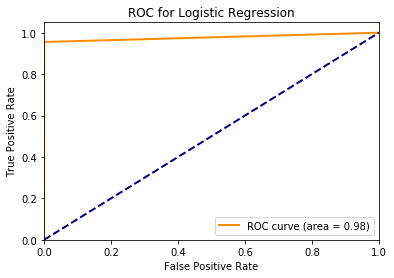

In [11]:
model_evaluation(X_train, X_test, y_train, y_test, y_predicted_train, y_predicted_test, title='Logistic Regression')

### 4.2. Linear discriminant analysis

LDA employs Bayes' theorem to fit a Gaussian density to each class of data. The classes are assumed to have the same covariance matrix. This generates a linear decision boundry. 

In [12]:
def LDA(X_train, y_train, X_test):
    
    """Classification using LDA 

    Args:
        X_train: Predictor or feature values used for training
        y_train: Response values used for training
        X_test: Predictor or feature values used for predicting the response values using the classifier

    Returns:
        y_predicted_train: The predicted response values for the training dataset
        y_predicted_test: The predicted response values for the test dataset

    """
    
    classifier = LinearDiscriminantAnalysis()
    classifier = classifier.fit(X_train, y_train)
    y_predicted_test = classifier.predict(X_test)
    y_predicted_train = classifier.predict(X_train)
    return y_predicted_train, y_predicted_test

In [13]:
y_predicted_train, y_predicted_test = LDA(X_train, y_train, X_test)

For the  Linear Discriminant  classifier:
Training set score: 0.994302
Training log-loss: 0.196797
Training set confusion matrix:
[[30366    58]
 [  118   347]]
Training set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30424
         1.0       0.86      0.75      0.80       465

    accuracy                           0.99     30889
   macro avg       0.93      0.87      0.90     30889
weighted avg       0.99      0.99      0.99     30889

Test set score: 0.995415
Test log-loss: 0.158378
Test set confusion matrix:
[[5375   10]
 [  15   52]]
Test set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5385
         1.0       0.84      0.78      0.81        67

    accuracy                           1.00      5452
   macro avg       0.92      0.89      0.90      5452
weighted avg       1.00      1.00      1.00      5452



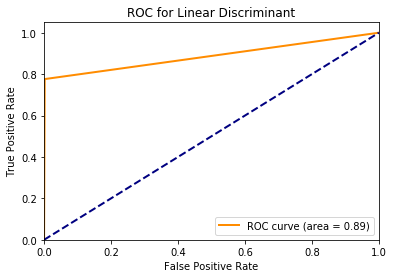

In [14]:
model_evaluation(X_train, X_test, y_train, y_test, y_predicted_train, y_predicted_test, title='Linear Discriminant')

### 4.3. Quadratic discriminant analysis

QDA is similar to LDA, however it employs a quadratic decision boundary, rather than a linear one.

In [15]:
def QDA(X_train, y_train, X_test):
    """Classification using QDA 

    Args:
        X_train: Predictor or feature values used for training
        y_train: Response values used for training
        X_test: Predictor or feature values used for predicting the response values using the classifier

    Returns:
        y_predicted_train: The predicted response values for the training dataset
        y_predicted_test: The predicted response values for the test dataset

    """
    classifier = QuadraticDiscriminantAnalysis()
    classifier = classifier.fit(X_train, y_train)
    y_predicted_test = classifier.predict(X_test)
    y_predicted_train = classifier.predict(X_train)
    return y_predicted_train, y_predicted_test

In [16]:
y_predicted_train, y_predicted_test = QDA(X_train, y_train, X_test)

For the  Quadratic Discriminant  classifier:
Training set score: 0.015604
Training log-loss: 34.000611
Training set confusion matrix:
[[   18 30406]
 [    1   464]]
Training set classification report:
              precision    recall  f1-score   support

         0.0       0.95      0.00      0.00     30424
         1.0       0.02      1.00      0.03       465

    accuracy                           0.02     30889
   macro avg       0.48      0.50      0.02     30889
weighted avg       0.93      0.02      0.00     30889

Test set score: 0.013573
Test log-loss: 34.070770
Test set confusion matrix:
[[   7 5378]
 [   0   67]]
Test set classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00      5385
         1.0       0.01      1.00      0.02        67

    accuracy                           0.01      5452
   macro avg       0.51      0.50      0.01      5452
weighted avg       0.99      0.01      0.00      5452



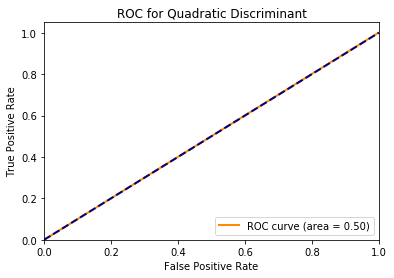

In [17]:
model_evaluation(X_train, X_test, y_train, y_test, y_predicted_train, y_predicted_test, title='Quadratic Discriminant')

## 5. Decision trees and random forest

### 5.1. Single decision tree

Decision trees are a non-parametric learning method used for both classification and regression. The advantages of decision trees are that they are easy to understand and they can be used for a broad range of data. However, the main disadvantages are that a single decision tree is easily overfitted and hence even small perturbations in the data might result in a markedly different classifier. This problem is tackled by generating several decision trees for deriving the final classifier. Here, we first train a single decision tree before we looking into more sophisticated ensemble methods.

We fit a single decision tree with default parameters and predict the values of $\mathbf{y}$ based on the test data.

In [18]:
def DecisionTree(X_train, y_train, X_test):
    
    """Classification using Decision Tree 

    Args:
        X_train: Predictor or feature values used for training
        y_train: Response values used for training
        X_test: Predictor or feature values used for predicting the response values using the classifier

    Returns:
        y_predicted_train: The predicted response values for the training dataset
        y_predicted_test: The predicted response values for the test dataset

    """
    
    classifier = tree.DecisionTreeClassifier()
    classifier = classifier.fit(X_train, y_train)
    y_predicted_test = classifier.predict(X_test)
    y_predicted_train = classifier.predict(X_train)
    return y_predicted_train, y_predicted_test

In [19]:
y_predicted_train, y_predicted_test = DecisionTree(X_train, y_train, X_test)

For the  Decision Tree  classifier:
Training set score: 1.000000
Training log-loss: 0.000000
Training set confusion matrix:
[[30424     0]
 [    0   465]]
Training set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30424
         1.0       1.00      1.00      1.00       465

    accuracy                           1.00     30889
   macro avg       1.00      1.00      1.00     30889
weighted avg       1.00      1.00      1.00     30889

Test set score: 0.998716
Test log-loss: 0.044346
Test set confusion matrix:
[[5381    4]
 [   3   64]]
Test set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5385
         1.0       0.94      0.96      0.95        67

    accuracy                           1.00      5452
   macro avg       0.97      0.98      0.97      5452
weighted avg       1.00      1.00      1.00      5452



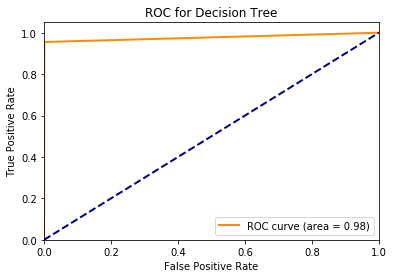

In [20]:
model_evaluation(X_train, X_test, y_train, y_test, y_predicted_train, y_predicted_test, title='Decision Tree')

### 5.2. Random forest

Radnom forest explanation...

In [21]:
def RandomForest(X_train, y_train, X_test):
    
    """Classification using Random Forest 

    Args:
        X_train: Predictor or feature values used for training
        y_train: Response values used for training
        X_test: Predictor or feature values used for predicting the response values using the classifier

    Returns:
        y_predicted_train: The predicted response values for the training dataset
        y_predicted_test: The predicted response values for the test dataset

    """
    
    rf_classifier = RandomForestClassifier(n_estimators=100)
    rf_classifier = rf_classifier.fit(X_train, y_train)
    y_predicted_test = rf_classifier.predict(X_test)
    y_predicted_train = rf_classifier.predict(X_train)
    return y_predicted_train, y_predicted_test

In [22]:
y_predicted_train, y_predicted_test = RandomForest(X_train, y_train, X_test)

For the  Random Forest  classifier:
Training set score: 1.000000
Training log-loss: 0.000000
Training set confusion matrix:
[[30424     0]
 [    0   465]]
Training set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30424
         1.0       1.00      1.00      1.00       465

    accuracy                           1.00     30889
   macro avg       1.00      1.00      1.00     30889
weighted avg       1.00      1.00      1.00     30889

Test set score: 0.998899
Test log-loss: 0.038010
Test set confusion matrix:
[[5385    0]
 [   6   61]]
Test set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5385
         1.0       1.00      0.91      0.95        67

    accuracy                           1.00      5452
   macro avg       1.00      0.96      0.98      5452
weighted avg       1.00      1.00      1.00      5452



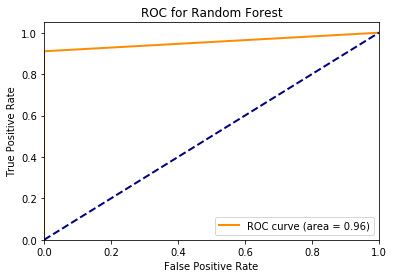

In [23]:
model_evaluation(X_train, X_test, y_train, y_test, y_predicted_train, y_predicted_test, title='Random Forest')

## 6. Neural Network

A Neural Network, also known as a multi-layered perceptron, is a supervised learning algorithm that learns a function, which is trained using a set of features and targets. A neural network can learns a non-linear function approximator, allowing classification of data. Between the input and output layers, there are a set of non-linear hidden layers. The advantages of a neural network are it's ability to learn non-linear models and perform learning in real-time. However, a NN can suffer from different validation accuracy induced by random weight initialization, has a large number of hyper parameters which require tunning and is sensitive to feature scaling. 

The neural_network function below makes use of inbuilt MLPClassifier, which implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation.

As MLPs are sensitive to feature scaling, the data is scaled using the built-in StandardScaler for standardization. The same scaling s applied to the test set for meaningful results.

Most of the MLPClassifier's parameters where left to random. However, several were modifed in order to enhance performance. Firstly, the solver was set to _adam_, which reffers to a stochastic gradient-based optimizer, the alpha regularization parameter was set to 1e-5, the number of hidden layers was set to 2, each with 70 neurons (numbers determined through experimentation throughout the day), and the max_iterations was set to 1500.

In [24]:
def neural_network(X_train, X_test, y_train, y_test):
    
    '''
    This function takes in the input datasets, creates a neural network, trains and then tests it.
    
    Written by AndreiRoibu
    
    Args:
        X_train (ndarray): 2D array of input dataset used for training
        X_test (ndarray): 2D array of input dataset used for testing
        y_train (ndarray): 1D array of train labels 
        y_test (ndarray): 1D array of test labels  
        
    Returns:
        predicted_train (ndarray): 1D array of model-predicted labels for the train dataset 
        predicted_test (ndarray): 1D array of model-predicted labels for the test dataset
        
    '''
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    classifier = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(70,70), random_state=1, max_iter=1500)
    
    classifier.fit(X_train, y_train)
    
    predicted_train = classifier.predict(X_train)
    predicted_test = classifier.predict(X_test)
    
    return predicted_train, predicted_test

In [25]:
y_predicted_train, y_predicted_test = neural_network(X_train, X_test, y_train, y_test)

For the  Neural Network  classifier:
Training set score: 1.000000
Training log-loss: 0.000000
Training set confusion matrix:
[[30424     0]
 [    0   465]]
Training set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30424
         1.0       1.00      1.00      1.00       465

    accuracy                           1.00     30889
   macro avg       1.00      1.00      1.00     30889
weighted avg       1.00      1.00      1.00     30889

Test set score: 0.999633
Test log-loss: 0.012670
Test set confusion matrix:
[[5384    1]
 [   1   66]]
Test set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5385
         1.0       0.99      0.99      0.99        67

    accuracy                           1.00      5452
   macro avg       0.99      0.99      0.99      5452
weighted avg       1.00      1.00      1.00      5452



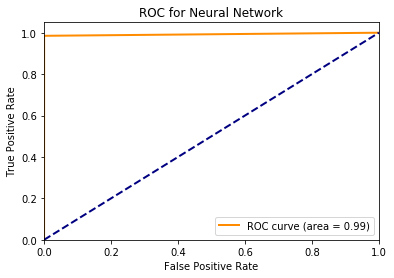

In [26]:
model_evaluation(X_train, X_test, y_train, y_test, y_predicted_train, y_predicted_test, title='Neural Network')